# Identifying Fraud Rings Using Social Network Analytics

Within the financial industry, an organization can expect to lose 3-6%, and up to 10%, of its [business to fraudulent activities](http://www.crowe.ie/wp-content/uploads/2019/08/The-Financial-Cost-of-Fraud-2019.pdf).  Fraudulent activities not only impact financial aspects, but victims often have negative views of the company, leading to negative market sentiment.  Overall, these fraudulent activities have a significant impact on a business, in terms of both consumer confidence and bottom-line revenue.  Due to the impact of these illicit activities on the bottom line, companies expend significant time and money to detect and prevent fraud.  

When dealing with fraud, there are two main components to a robust fraud system., fraud detection and fraud prevention.  In fraud detection component of a system, the main goals are to develop a system and methodology that allows for the rapid discovery of fraudulent activities.   This usually involves a posterior evaluation of data, such as transaction, users, credit cards, etc. to determine what patterns or combinations represent actual fraud.  This process usually involves a human-in-the-loop system where automated processes flag likely or potential fraudulent activities, which are then evaluated by an expert in the domain to determine the legitimacy, or ill-legitimacy, of the activities flagged.  The output of this process is a set of known and evolving patterns of fraud that are fed into a fraud prevention system.   Generally, this consists of a real-time system that compares a transaction, or a set of transactions, against the known fraudulent patterns identified by the fraud detection system.  The objective of this fraud prevention system is to reduce and prevent fraudulent activities from occurring in the first place. 


## Challenges of Detecting Fraud

When dealing with fraud, it is often helpful to understand some challenges of finding fraudulent activities when looking into data.  Often this is aided by first understanding the definition and nature of fraud.  While there are many definitions of what fraud is my favorite is:

[Fraud is an uncommon, well-considered, imperceptibly concealed, time-evolving and often carefully organized crime which appears in many types of forms .](https://www.amazon.com/Analytics-Descriptive-Predictive-Network-Techniques/dp/1119133122)


This definition highlights the complex nature of the problems we must address when working on fraud systems.  First, fraud is *uncommon*.  Within any system of recorded transactions, only a small fraction of these transactions consist of fraudulent or illicit activities.  The sparse nature of these illicit activities complicates the nature of identifying these activities.  Second, fraud is *well-considered* and *imperceptibly concealed,* meaning that fraudulent activities are rarely impulsive activities.  Most fraudulent activities, at least at scale, involve multiple parties colluding together to perform actions specifically designed to exploit weaknesses in the system and elude detection.  Finally, fraud is *time-evolving*.  Fraudsters are continuously evolving and adapting their techniques as detection and prevention improve in an endless game of hide and seek.

With these challenges in mind, many fraud detection systems take a multifaceted approach to identifying illicit activities.   In this notebook, we will focus on the use of social networks implicitly found in fraud data to identify fraud rings committing illicit transactions using a guilt-by-association approach.

Fraud rings are a common issue within the industry and consist of multiple individuals or entities colluding to defraud a system.  These rings may consist of family members, acquaintances, or even buyer/seller pairs that span both sides of a transaction.  These rings exist across a wide array of industries, but an important aspect of these fraud rings, at least as it is related to graph analysis, is that they are strongly linked groups of entities.  

## Creating a fraud graph

In this section we'll load the fraud graph and set some visualization options. We'll then use some Gremlin queries to inspect the data model used throughout the solution.

### Load data
The cell below loads the example fraud graph into your Neptune cluster. When you run the cell below a graph for an example Fraud dataset will load., which will take about 5 minutes.

In [ ]:
%seed --model Property_Graph --dataset fraud_graph --run

Now we will install the library we will be using later on in this notebook.  You may need to restart the kernel by going to the menu and selecting the item shown:

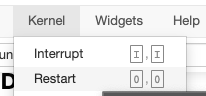

Once you have done this, please reload this browser page and continue.

In [ ]:
pip install awswrangler -q

### Set visualization and configuration options

The cell below configures the visualization to use specific colors and icons for the different parts of the data model.

In [ ]:
%%graph_notebook_vis_options

{
  "groups": {
    "Account": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf2bb",
        "color": "red"
      }
    },
    "Transaction": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf155",
        "color": "green"
      }
    },
    "Merchant": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf290",
        "color": "orange"
      }
    },
    "DateOfBirth": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1fd",
        "color": "blue"
      }
    },
    "EmailAddress": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1fa",
        "color": "blue"
      }
    },
    "Address": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf015",
        "color": "blue"
      }
    },
    "IpAddress": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf109",
        "color": "blue"
      }
    },
    "PhoneNumber": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf095",
        "color": "blue"
      }
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": false,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "minVelocity": 0.75,
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -50450,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "solver": "barnesHut",
    "enabled": true,
    "adaptiveTimestep": true,
    "stabilization": {
      "enabled": true,
      "iterations": 1
    }
  }
}

### Data model
The fraud graph included in this example models credit card accounts, account holder information, merchants, and the transactions performed when an account holder purchases goods or services from a merchant.

**Account and features**

An Account has a number of features, including physical Address, IpAddress, DateOfBirth of the account holder, EmailAddress, and contact PhoneNumber. An account holder can have multiple email addresses and phone numbers.

In many graph data models these features of the account holder would be modelled as properties of the account. But with fraud detection it's important to be able to link accounts based on shared features, and to find related accounts at query time based on one or more shared features. Hence, our fraud detection application graph data model stores each feature as a separate vertex. Multiple accounts that share the same feature value - the same physical address, for example - are connected to the single vertex representing that feature value. For more details on modelling shared features as vertices, see Relating entities through their attributes at query time.

The following query shows a single account and its associated features. After running the query, click the Graph tab to see a visualization of the results.

### What does my fraud graph look like for an account?

In [ ]:
%%oc -d value -l 20
MATCH p=(n)-[]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

### What if I only want to look at the account properties, not the transactions?

While the transaction information is very important, but it is often overwhelming, especially on very active accounts.  Often we want to look at only account features, to see how that specific account is connected to features of that account.

In [ ]:
%%oc -d value -l 20
MATCH p=(n)-[:FEATURE_OF_ACCOUNT]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

### What else connects to these same features?

After isolating only the account features, we may want to extend our exploration out further to see if we can find other accounts that sharing these features.

In [ ]:
%%oc -d value -l 20
MATCH p=(n)-[:FEATURE_OF_ACCOUNT*1..2]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

Well, this is starting to show some interesting information.  As we can see above there a four other accounts that all share the same birthday and one that shares the same phone number.  Having a shared birthday does not seem too suspicious, as there are only so many, but sharing a birthday and sharing a phone number, that seems unlikely.

### Find accounts with shared features?

Let's take a look at what it looks like if we find all accounts that share a feature, other than a `DateOfBirth`, with another account.

In [ ]:
%%oc -d value -l 20
MATCH p=(n:Account)<-[:FEATURE_OF_ACCOUNT]-(f)-[:FEATURE_OF_ACCOUNT]->(t:Account)
WHERE NOT f:DateOfBirth
RETURN p

That is a lot of shared features, in fact if we start to examine this data it begins to look a lot like a social network.  In fact, using social network analytics on top of this type of graph does allow us to find many interesting insights that are not apparent in the original transaction graph.

## Finding Fraud Rings in your social graph

When analyzing graph data, a frequent requirement is to infer information/connections from the underlying graph into a different graph form to enable analytics and algorithms to run on it.  Many graphs in Neptune contain a rich collection of entities and attributes, such as our transaction graph, that while useful for transactional queries, are not required to perform analytical tasks.

### Inferring a social graph from your fraud graph

In this example we are going to create a social graph by inferring that any accounts that are connected by a feature, other than `DateOfBirth`, are connected within this social network.  We will then use this social network to search for rings of fraudulent accounts within this social graph.

Up until now we have been working with Amazon Neptune directly.  For this analysis we are going to leverage an integration between Neptune and Pandas DataFrames, supplied by [AWS Data Wrangler](https://github.com/awslabs/aws-data-wrangler), to read and write data from Neptune and the [iGraph](https://igraph.org/) library to perform network analysis/graph algorithms on top of this data.

Running the cell below will retrieve that needed data from Neptune, in this case an [edge list](https://en.wikipedia.org/wiki/Edge_list), and load it into a Pandas DataFrame that we will use for later analysis.  

In [ ]:
import awswrangler as wr
import pandas as pd
import igraph as ig
import graph_notebook as gn
from graph_notebook.configuration.generate_config import AuthModeEnum

# Get the configuration information for the notebook
config = gn.configuration.get_config.get_config()
iam=True if config.auth_mode==AuthModeEnum.IAM else False

# Retrieve Data from neptune
client = wr.neptune.connect(config.host, config.port, iam_enabled=iam)
query = """MATCH (s:Account)<-[:FEATURE_OF_ACCOUNT]-(f)-[:FEATURE_OF_ACCOUNT]->(t:Account) 
WHERE NOT f:DateOfBirth RETURN id(s) as source, id(t) as target"""
df = wr.neptune.execute_opencypher(client, query)
display(df.head(10))

### Detecting strongly linked communities

Fraud rings are a common issue within the industry and consist of multiple individuals or entities colluding to defraud a system.  These rings may consist of family members, acquaintances, or even buyer/seller pairs that span both sides of a transaction.  These rings exist across a wide array of industries, but an important aspect of these fraud rings, at least as it is related to graph analysis, is that they are strongly linked groups of entities.  

In networking analysis/graph algorithms there is an entire class of algorithms, known as community detection algorithms, that evaluate how groups of nodes are connected or partitioned from one another Use community detection algorithms to determine strongly linked groups of entities.  While there are a large number of these algorithms the most common community detection algorithms used are Weakly Connected Components, Louvain, and Label Propagation.  

#### Finding strongly linked communities

Now that we have created our social graph, the first step in analyzing this graph for fraud rings is to find the communities of strongly connected entities which may represent collusion.  Running the cell below will run the Weakly Connected Components algorithm on the data, which will assign a unique component value to all vertices in the graph that are connected by a path, regardless of the edge direction.

In [ ]:
# Create a graph from the results returned
g = ig.Graph.TupleList(df.itertuples(index=False), directed=True, weights=False)

# Run WCC on the data
wcc = g.clusters(mode="weak")
print(f'Their are {len(wcc)} communities in this data set.')

giant=wcc.giant()
print(f'The largest community has {len(giant.vs)} accounts.')

print(f'The size histogram for these clusters is:')
print(wcc.size_histogram())


Running this algorithm we see that our dataset contains 123 communities with the largest one having 18 accounts.  From looking at the size histogram we can also see that there are two clusters which have an anomalously large number of accounts.  Since this is often a sign of collusion between accounts, let us further examine the largest of these communities.

### Identifying most important members in a community

Once a set of communities are identified, the next step involves identifying the most important entities in one or more of those communities.  This is accomplished using a centrality algorithm, which will identify the most important entities, enabling analysts to start their investigation with the “big fish” in the potential ring.  There are many different centrality algorithms, each providing a slightly different method for determining the importance of a node. The most commonly used ones are: Degree, PageRank, Betweenness, Closeness, and Eigenvector.

For our analysis below we will run [PageRank](https://en.wikipedia.org/wiki/PageRank) which is an algorithm that was originally developed to rank web pages but is now commonly applied to many other problems.  PageRank returns a value that represents the relative importance of an account within a community based on it's relationships and the importance of the corresponding accounts.  In the end the higher the PageRank value returned, the more important the account is inside the community.

In [ ]:
pg = giant.pagerank()
print('\n'.join(map(str, pg)))

Great, we have now analyzed our inferred social network to identify the strongly connected communities within that network and prioritized the most important accounts within the anomalous community.  Now that we have done this analysis we need to save this data back into our original graph to enable investigations by trained fraud analysts. 

### Storing the risk values back into the graph

To store our data back into our original graph we can once again use our AWS Data Wrangler integration to save a Pandas DataFrame into Neptune.  To accomplish this we will first construct a DataFrame consisting of the account id, as well as the community/component value, as well as the associated PageRank value.  We then save this DataFrame back to Neptune using the [`to_property_graph()`](https://aws-data-wrangler.readthedocs.io/en/stable/stubs/awswrangler.neptune.to_property_graph.html#awswrangler.neptune.to_property_graph) method. 

In [ ]:
rows=[]
for idx, c in enumerate(wcc):
    for item in c:
        rows.append({'~id': str(g.vs[item]['name']), 'component(single)': idx})

for idx, v in enumerate(giant.vs):
    r = next(s for s in rows if s['~id'] == v['name'])
    r['pg(single)']  = pg[idx]

new_df=pd.DataFrame(rows, columns=['~id','component(single)', 'pg(single)'])
res = wr.neptune.to_property_graph(client, new_df, use_header_cardinality=True, batch_size=100)
print("Save Complete")

## Analyzing the results


A critical and ongoing part of any fraud workflow is to have a mechanism to enable analysts to investigate and prove/disprove that a potentially fraudulent activity exists.  

### Find the most important accounts to examine first

A common workflow for a skilled fraud analyst is to start by retrieving a list of prioritized accounts to look at based on the “risk” associated with the entity.  In the query below we will find the top 5 most important accounts to examine.

In [ ]:
%%oc -d value -l 20

MATCH (a:Account) WHERE a.pg IS NOT NULL RETURN id(a), a.component, a.pg ORDER BY a.pg DESC LIMIT 5

### Explore their connections
The ability to visually explore graphs is a powerful tool that helps fraud analysts understand how certain account are connected.  Let's take a look at the most important account information and see the graph of the surrounding connections. 

In [ ]:
%%oc -d value -l 20

MATCH p=(a)-[*1..2]-()
WHERE id(a)='account-4398046511937'
RETURN p

### Mark as Fraud/Not Fraud

Visual inspection, combined with the domain expertise of a fraud analyst, is a critical factor in being able to determine if anomalous patterns in a graph represent actual fraud or legitimate activity.  Expert analysts are capable at looking at the patterns of transactions and connections and the structural connections between items to determine the legitimacy of an account/transaction.  Once they have made this determination they will often flag these accounts/transactions as fraudulent in the graph to aid in future investigations.

Let's mark the account above as fraudulent by setting the `isFraud` property to `True`

In [ ]:
%%oc -d value -l 20
MATCH (a)
WHERE id(a)='account-4398046511937'
SET a.isFraud=True
RETURN a

### Find all fraudulent accounts within five hops 

Now that we have completed our investigation of `account-4398046511937` let's take a look at another account from our list above `account-21990232559534`.  In addition to looking at the connections for an account, as shown above, another common use of graphs when analyzing anomalous activity is to look how closely an account is connected to a known fraudulent account. 

Let's take a look at this new account and see if it is connected to any marked fraudulent accounts.

In [ ]:
%%oc -d value -l 20

MATCH p=(a)-[:FEATURE_OF_ACCOUNT|ACCOUNT*1..5]-(b)
WHERE id(a)='account-21990232559534'
AND b.isFraud=True
RETURN p LIMIT 1

Wow, that account shares a phone number with a known fraudster so it looks suspicious.

## Conclusion

Combating fraud is an ongoing challenge for any organization.  The more and faster a team can identify fraud the more efficient anti-fraud systems become, preventing significant financial losses.  Finding and understanding fraud rings is a problem that requires the ability to query, analyze, and explore the connections between accounts, transactions, and account features.  Combining the ability to query a graph with the ability to run network analysis/graph algorithms on top of that data enables us to derive novel insights from this data.  